In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import PandasTools

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import normaltest

from utils import get_statisicts
from utils import pearson_confidence
from utils import max_possible_correlation
from utils import cluster_fps
from utils import get_data
from utils import get_sim_data

import pandas as pd

sns.set()

Below, there are some of the simulation results, analyses, and my comments regarding the models' performance. (Last update 01/03/20).

## Model trainig, cross-validation, and evaluations

Model descriptions (brief):      
1. `ESOLCalculator`: [Multivariate regression model](https://en.wikipedia.org/wiki/General_linear_model) based on the [ESOL model](https://pubs.acs.org/doi/10.1021/ci034243x).   
2. `RFRegressor`: [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) trained on 1024 bits of [ECFP4](https://pubs.acs.org/doi/10.1021/ci100050t) and implemented with [scikit-learn](https://scikit-learn.org/stable/).  
3. `NfpRegressor`: Convolutional neural network trained on the [molecular graphs](https://github.com/HIPS/neural-fingerprint).
4. `EnsembleRegressor`: [Keras](https://keras.io/) implementation of one dense layer neural network with 28 (3+25) features. Three features are predictions from the above methods (trained with the same training dataset), and the remaining 25 features are [RDKit](https://www.rdkit.org/) physical properties. The idea is that since the models/featrues are not perfectly correlated (Pearson's $R\ne1$), combining them gives more robust predictions. In a sense, this model is similar to the [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) (and [Pat's code](https://github.com/PatWalters/stacking_regressors/blob/master/stacking_regressors.py)). In our case we are "stacking" two linear models (ESOL and MLR with 25 features), plus RF and NFP.



Each model is trained and validated using 5 cross-fold validation. During each cross-validation, the mean square error (mse) and Preason's $R^2$ were calculated.
**No hyperparameters optimization was performed**. (naively)validation sets (and the performance calculated for them) can be taken as the general performance on the Test Sets. **The fallacy of this assumption/procedure will be discussed in the second section**.           

The training set consists of 1865 data points for `solubility.uniq.no-in-100.smi` (or 1912 for `solubility.uniq.no-in-32.smi`) compounds with measured $\rm{log}S_0$. Each of these two datasets contain unique compounds, and all the compounds from Test Set 1 (TS-1) and Test Set 2 (TS-2) are excluded from the training set.  

The results below are for 4 models: ESOL, Random Forest (RF), Neural Fingerprint (Nfp), and Ensemble methods. 
For comparison, I also added data from the [putatively](https://github.com/pgniewko/solubility/blob/master/src/notebooks/assets/mpnn.moleculenet.png) best model (MPNN) that I found at the [MoleculeNet website](http://moleculenet.ai/). Because error bars were not provided, for plotting purposes, I set them to 0.

In [2]:
CURRENT_PATH = os.getcwd()
RESULTS_PATH = '{}/../../results'.format(CURRENT_PATH)

ESOLCalculator:	 0.7493291399122787 0.7861647391624803
EnsembleRegressor:	 0.8155966977018461 0.8436782454942452
MPNN:	 0.9334064465659521 0.9441377386957225
NfpRegressor:	 0.7312951337580055 0.7703773611852874
RFRegressor:	 0.659391213102679 0.7068128045156173


Text(0, 0.5, "Theoretical max. value of Pearson's R**2")

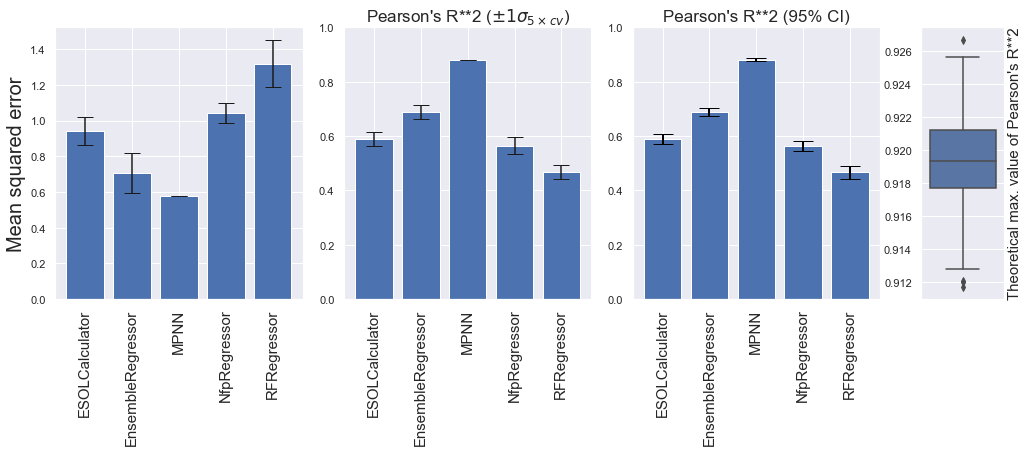

In [2]:
#The code below reads the data saved at the end of the trainig and validation, analyses and plots the results.
models_data_files = ['esol-no-in-100.dat',
                     'rf-no-in-100.dat',
                     'nfp-no-in-100.dat',
                     'ensemble-no-in-100.dat',
                     'mpnn.delaney.dat']

statistics_map = {'mse':0, 'mae':1, 'pearsonr':2}


# Read logS0 values used for training and cross-validation
logS0 = []
logS0_FILE = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)
with open(logS0_FILE, 'r') as fin:
    for line in fin:
        pairs = line.rstrip('\n').split(',')
        logS0.append(float(pairs[1]))

num = len(logS0)

fig = plt.figure(figsize=(17,5))
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[3,3,3,1])
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[0,2])
ax4 = fig.add_subplot(spec[0,3])
ax2.set_ylim([0,1])
ax3.set_ylim([0,1])

# Mean square error
models_mse = get_statisicts('mse', models_data_files, statistics_map, RESULTS_PATH)
vals = [models_mse[key][0] for key in sorted(models_mse.keys())]
std = [models_mse[key][1] for key in sorted(models_mse.keys())]
ax1.bar(sorted(models_mse.keys()), vals, yerr=std,capsize=8)
ax1.set_xticklabels(sorted(models_mse.keys()), rotation=90, fontsize=15)
ax1.set_ylabel('Mean squared error', fontsize=20)

# Pearson's R
models_pearsonr = get_statisicts('pearsonr', models_data_files, statistics_map, RESULTS_PATH)
vals = [models_pearsonr[key][0]**2.0 for key in sorted(models_pearsonr.keys())]
std = [models_pearsonr[key][1] for key in sorted(models_pearsonr.keys())]
ax2.bar(sorted(models_pearsonr.keys()), vals, yerr=std,capsize=8)
ax2.set_xticklabels(sorted(models_pearsonr.keys()), rotation=90, fontsize=15)
ax2.set_title('Pearson\'s R**2 ($\pm 1\sigma_{5\\times cv}$)', fontsize=17)

# Confidence intervals
lb = []
ub = []
for model in sorted(models_pearsonr.keys()):
    values = models_pearsonr[model]
    r = values[0]**0.5 # R^2 --> R
    rlower, rupper = pearson_confidence(r, num, interval=0.95)
    lb.append(r**2 - rlower**2) # In respect to R^2
    ub.append(rupper**2 - r**2) # In respect to R^2
    print("{}:\t {} {}".format(model, rlower**2, rupper**2))
    
ax3.bar(sorted(models_pearsonr.keys()), vals, yerr=None)
ax3.errorbar(sorted(models_pearsonr.keys()), vals, yerr=[lb,ub], fmt="none", capsize=10, elinewidth=2,color='black')
ax3.set_xticklabels(sorted(models_pearsonr.keys()), rotation=90, fontsize=15)
ax3.set_title('Pearson\'s R**2 (95% CI)', fontsize=17)

ax4.yaxis.set_label_position("right")
_, pr_corrs =  max_possible_correlation(logS0, error=0.6, cycles=500)
sns.boxplot(np.array(pr_corrs)**2.0, ax=ax4, orient='v')
ax4.set_ylabel('Theoretical max. value of Pearson\'s R**2', fontsize=15)

The first plot from the left provides average MSE values (and standard deviations calculated over 5 cross-folds). Among 4 trained models, `EnsembleRegressor` is the best one, but it's outperformed by the `MPNN` model. Surprisingly, the performance of `MPNN` is below $MSE \approx 0.6 \rm{log}~units$, which raises some concerns in the context of putative experimental accuracy being about [`0.62`](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00345) log units. When we look at the Pearson's $R^2$ coefficient, we can still see that `EnsembleRegressor` performs best. 95% confidence intervals are estimated [analytically](https://github.com/pgniewko/solubility/blob/master/src/notebooks/utils.py). Error bars between `EnsembleRegressor` don't overlap with the others; thus, at this confidence level we can say the `Ensemble` method is performing [better](https://www.ncbi.nlm.nih.gov/pubmed/26942422) than the other methods (except `MPNN`). However, all these four methods are outperformed by `MPNN`, with Pearson's $R^2$ reported to be 0.939. I checked the maximum possible Pearson's $\left<R^2\right>$ (as suggested [here](https://practicalcheminformatics.blogspot.com/2019/07/how-good-could-should-my-models-be.html)), with the assumption that the standard error is $0.6 \rm{log}~units$ (following this [paper](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00345)). This calculation suggests that the theoretical maximal value of $R^2$ is in the range of $\approx[0.912, 0.928]$ (the 95% CI ). We can see that `MPNN` is not only reaching, but even exceeding, theoretical performance. In defense of `MPNN`, I will mention that the model was trained and evaluated on the original Delaney dataset (about 1200 compounds), which, by the way, makes up the majority of the training data in this work.

### Some comments on the correlation between methods

The predictions from the algorithms discussed above are likely correlated. When the 95% CIs intervals overlap, or the statistics difference is smaller than the error bars, we cannot definitely conclude the difference (or equivalence) of two methods (except in the case where one error bar is enclosed by another, [Nicholls, A. 2016](https://www.ncbi.nlm.nih.gov/pubmed/26942422)). In such a case, pairwise correlation coefficients are required. For our case, since the methods are studied on the same dataset, this is easily feasible. Otherwise, the correlation coefficient for two methods $X$ and $Y$ can be [estimated](https://www.ncbi.nlm.nih.gov/pubmed/26942422) based on their correlation coefficients with the target dataset, $R_X$ and $R_Y$, as $R_{XY} \approx R_XR_Y$. This approximation assumes that the source of the noise in each of the models is independent - which may not be the case if models differ only slightly and are based on the same physical principles. If so, the direct evaluation of the Pearson's $R$ (if no other prior knowledge is available) is necessary to properly estimate CIs for the difference between X and Y. 

### _y-randomization_ of the training dataset

With ESOL we have a small number (4) of features and we want to test to what extent the correlation between features can be used to predict randomized response variables (i.e. $\rm log S_0$), a procedure called [y-Randomization](https://pubs.acs.org/doi/abs/10.1021/ci700157b). The idea behind y-randomization is to break the relation between the features (descriptors) and related values. This procedure is especially valuable as a baseline to judge multilinear regression models with features selection (to get the best fit to the given data). In this project, we do not select features that best fit the data, so this calculation gives us only an idea about the performance that we would expect in case of the broken relation between the features and target values.         

Not surprisingly, the correlation between the input and the output data is negligible (Pearson's $R\approx 0$). 95% CIs are approximated by the $2\sigma$ intervals assuming the errors have a symmetric distribution (calculated over 5 cross-folds). This assumption is likely violated for $R^2\approx 1$, but because the differences between the models and the baseline are much larger than $2\sigma$, the conclusions should stay the same upon the application of asymmetric correction. In short, the results in the table below show that the trained model significantly improves over predictions on the "y-randomized" data.

|Method| MSE ($\pm2\sigma$)  | MAE ($\pm2\sigma$)| Pearson's $R^2$ ($\pm2\sigma$)|        
|------|------------|------------|------------|   
|ESOL| 4.069 ($\pm$0.406) | 1.573 ($\pm$0.078) |  0.010($\pm$0.012) |      
|RF| 4.563 ($\pm$0.858) | 1.667 ($\pm$0.160) |  0.001 ($\pm$0.002) |    
|Nfp| 4.136 ($\pm$0.454) | 1.585 ($\pm$0.086) |  0.005 ($\pm$0.003) |   
|Ensemble|  4.878 ($\pm$0.512) | 1.737 ($\pm$0.072) |  0.006 ($\pm$0.012) |   

Table: Values for the "mode 2" y-randomization (refer to [this paper](https://pubs.acs.org/doi/abs/10.1021/ci700157b) for more details). Target variables were randomly permutated (shuffled). All descriptors/features are kept when building the model. MSE - mean squared error; MAE - mean absolute error.

# Evaluation on Test Set 1 and Test Set 2

For each method, 5 models were trained based on 4/5 of the data (random compound split). The final prediction of the $\rm logS_0$ values is taken as an average over these 5 different models (cross-folds).        

|Method| TEST SET 1 (100 compounds) | TEST SET 2 (32 compounds) |   
|------|------------|------------|
|ESOL| 1.21 (35%) | 1.25 (31%) |
|RF| 1.33 (34%) | 2.59 (16%) |
|Nfp| 1.62 (26%) | 2.62 (6%) |
|Ensemble| 1.01 (46%) | 1.69 (28%) | 
|GSE | 1.12 | 1.19 |

Table: GSE is RMSE [provided](https://github.com/pgniewko/solubility/blob/master/data/raw/LA.2019.JCIM.xlsx) for the whole datasets. n parenthesis, the percentage of correct (+/- 0.5logS0) prediction.

From the results above (obtained with the `evaluate_model.py` script), it is quite clear that, despite a good performance on the training and validation datasets, the performance on the two independent datasets is noticeably lower. We can see that the Ensemble method performs best on the TS-1, but it's performance is slightly lower on TS-2. Interestingly, RF and NFP performs rather poorly on the two test sets. It probably means that these two methods generalized poorly and/or are overfitted. Poor generalizability of these two methods impacts the performance since TS-1 and TS-2 are drawn from a different distribution that the training set (see the section below). Overfitting can result from lack of regularization and its application would likely improve the performance. In order to understand why the models don't generalize well, I plotted $\rm logS_0$ values for the training set and as a reference, $\rm{log}S_0$ values from the  General Solubility Equation ([GSE](https://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html)).

Interestingly, the above results are in a very good agreement with the [current evaluation of the challange](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.0c00701) _by Llinas et al_. The results both for MLP and NN are on par with the majority of the predictions submitted by the contestants of the second challenge. This is very encouraging especially since in this work we didn't perform any substantial hyper-parameters optimization.  

Finally, the simple ESOL model performs best on the TS-2 and comparably well on TS-1. It is because the model has only 4 parameters therefore it is difficult to get this model overfitted. Additionally, the model stems from physics-based arguments, therefore its generalizability is assured by design.

In [3]:
def plot_data(fname, ax, label='', col=1, header=False):
    vals = get_data(fname, col=col, header=header)
    sns.distplot(vals,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
                )

def plot_sims(tarining_fname, target_file, ax, nbins=40, label=''):
    mol_sims = get_sim_data(tarining_fname, target_file)
    sns.distplot(mol_sims,
                 bins=nbins,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
            )

def plot_effective_size(fname, ax):
    smiles = []
    with open(fname, 'r') as fin:
        for line in fin:
            pairs = line.rstrip('\n').split(',')
            smiles.append(pairs[0])

    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=1024) for x in smiles]

    thrs = np.linspace(0.01, 0.99, 15)
    x = []
    y = []
    for _, thr in enumerate(thrs):
        clusts = cluster_fps(fps, cutoff=thr)
        x.append(1.0 - thr)
        y.append(len(clusts) / len(smiles))

    sns.lineplot(x, y, ax=ax, label='Training Set', lw=2)
    ax.plot([0.4, 0.4], [0, 1], '--', lw=2)

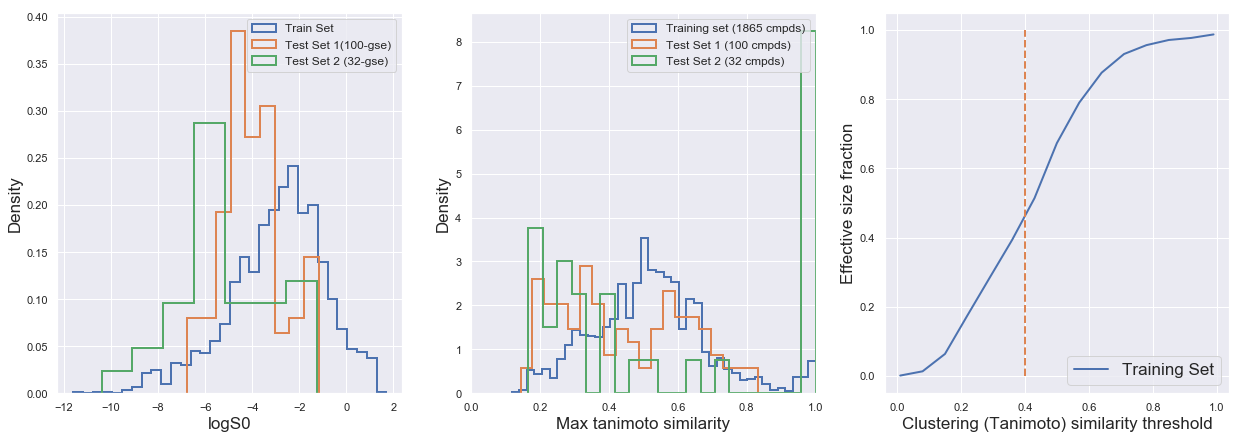

In [7]:
fig, axis = plt.subplots(1, 3, figsize=(21,7))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]

ax2.set_xlim([0,1])

# Input files
training_set_file = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)
f_100 = '{}/../../data/test/set1_logS0.csv'.format(CURRENT_PATH)
f_32 = '{}/../../data/test/set2_logS0.csv'.format(CURRENT_PATH)
set_100_smiles_file = '{}/../../data/test/test_100.smi'.format(CURRENT_PATH)
set_32_smiles_file = '{}/../../data/test/test_32.smi'.format(CURRENT_PATH)

# Subplot 1
plot_data(training_set_file, ax1, 'Train Set')
plot_data(f_100, ax1, 'Test Set 1', col=2, header=True)
plot_data(f_32, ax1, 'Test Set 2', col=2, header=True)
ax1.set_xlabel("logS0", fontsize=17)
ax1.set_ylabel("Density", fontsize=17)
ax1.legend(fontsize=12)

# Subplot 2
plot_sims(training_set_file, training_set_file, ax2, nbins=40, label='Training set (1865 cmpds)')
plot_sims(training_set_file, set_100_smiles_file, ax2, nbins=20, label='Test Set 1 (100 cmpds)')
plot_sims(training_set_file, set_32_smiles_file, ax2, nbins=20, label='Test Set 2 (32 cmpds)')
ax2.set_xlabel("Max tanimoto similarity", fontsize=17)
ax2.set_ylabel("Density", fontsize=17)
ax2.legend(fontsize=12)


# Subplot 3
plot_effective_size(training_set_file, ax3)
ax3.set_xlabel("Clustering (Tanimoto) similarity threshold", fontsize=17)
ax3.set_ylabel("Effective size fraction", fontsize=17)
ax3.legend(fontsize=17)

plt.show()

The distributions above hint to the reason why the models perform poorly on the Test Set 1 and especially on the Test Set 2. As we can see (the first plot from the left), the compounds in the testing sets TS-1 and TS-2 are not drawn from the same distribution. The [mode](https://en.wikipedia.org/wiki/Mode_(statistics)) of $\rm logS_0$ for the training set is around $mode(\rm{log}S_0)\approx -2$, whereas it's about $mode(\rm{log}S_0)\approx -4$ for TS-1 and $mode(\rm{log}S_0)\approx -6$ for TS-2. The fact that the physico-chemical space (i.e. logS0) for these two sets overlap only partially with the physico-chemical space of the training set, explains the poor performance of the models; especially in the Random Forest case. This is further backed up by the chemical similarity (middle plot). This plot provides the maximal Tanimoto similarity between the training set and the compounds from the training (excluding identity; blue line), Test Set 1 (orange line) and Test Set 2 (green line). We can see that the similarity trends follow the $\rm logS_0$ trends - as the physico-chemical properties differ more from the training sets, the similarity also drops. As a side note, the peak at `similarity=1` for the Test Set 2 comes from analogous compounds that gave rise to the same ECFP4 fingerprints (see below). 

Finally, it's important to mention that the amount of the training data is rather small, c.a 1900 data points. For such a small data size, it's not surprising that the Deep Learning methods do not deliver an expected performance, but rather, perform on par with the classical ML methods (or worse). However, the plot in the middle (and visual inspection of the training dataset) suggests that the training set contains many chemical analogs. Because of that, datapoints can be strongly correlated, and their contribution can be relatively lower than the data points from a distinct part of the chemical space. To check the span of the compounds in the training set, we clustered the compounds using the [Butina] algorithm at different similarity thresholds. The assumption is that compounds in a cluster contribute little to no of the novel chemical information, and a single representative of the cluster suffices for the entire cluster of analogs. As we can see in the right-most figure, at the threshold $\approx 0.4$, the number of the original data points is reduced by about 55% (compounds with the Tanimoto similarity $>0.4-0.5$ are usually considered analogs). Thus, the effective size of the training dataset is even lower, about 850. In that perspective, it becomes more clear that a relatively simple `ESOL` model generalizes better because it is physics-based, has few fitting parameters, and has less capacity to overfit on the training dataset.

### Analysis of the Linear Regression Model: ESOL

Building a linear regression model by minimizing the mean square error is equivalent to the maximum likelihood estimation procedure with the normally distributed and homoscedastic errors. This section checks if this assumption holds for linear regression models like ESOL

In [ ]:
# First we load the data from the file. 
# First column are the experimental values and the second column are the predicted values.

esol_linear_reg = '{}/../../results/esol-no-100.pred-exp.linear.dat'.format(CURRENT_PATH)
data = np.loadtxt(esol_linear_reg)
y_exp, y_pred = data[:,0], data[:,1]

####  Analysis of the residuals


Percentage of the datapoints above 1.96 std: 6.089743589743589 (expected 5%)
Percentage of the datapoints above 2.576 std: 1.8162393162393162 (expected 1%)
Shapiro-Wilk Test: Sample does not look Gaussian (reject H0):  p-value=9.248443677556395e-11
D’Agostino’s K^2 Test: Sample does not look Gaussian (reject H0):  p-value=4.981334626099735e-13


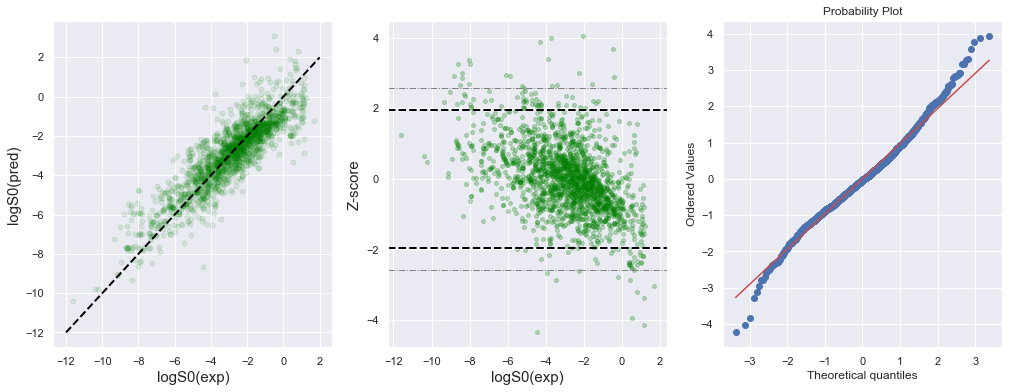

In [6]:
fig, axis = plt.subplots(1, 3, figsize=(17, 6))
ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]

# Plot exp vs. pred. values
ax1.plot(y_exp, y_pred, '.', color='green', alpha=0.1, ms=10)
ax1.plot([-12, 2], [-12, 2], '--',  color='black', lw=2)
ax1.set_xlabel("logS0(exp)", fontsize=15)
ax1.set_ylabel("logS0(pred)", fontsize=15)

# Plot scaled residuals (Z-transformed residuals)
z_scores = ((y_pred-y_exp) - np.mean( y_pred-y_exp))/ np.std(y_pred-y_exp)
#ax2.plot(y_exp[z_scores<0], abs(z_scores[z_scores<0]), '+', color='blue',alpha=0.75, ms=8)
ax2.plot(y_exp, z_scores, '.', color='green',alpha=0.25, ms=8)
ax2.axhline(y=1.96, color='black', linestyle='--', lw=2)
ax2.axhline(y=-1.96, color='black', linestyle='--', lw=2)
ax2.axhline(y=2.576, color='grey', linestyle='-.', lw=1)
ax2.axhline(y=-2.576, color='grey', linestyle='-.', lw=1)
ax2.set_xlabel("logS0(exp)", fontsize=15)
ax2.set_ylabel("Z-score", fontsize=15)

frac_95 = 100*sum(abs(z_scores) > 1.96) / (len(z_scores))
frac_99 = 100*sum(abs(z_scores) > 2.576) / (len(z_scores))
print(f'Percentage of the datapoints above 1.96 std: {frac_95} (expected 5%)')
print(f'Percentage of the datapoints above 2.576 std: {frac_99} (expected 1%)')

#  Q-Q plot, for the visual assesment. 
qq = stats.probplot(y_pred-y_exp, dist="norm", plot=ax3)

# Normality tests
from scipy.stats import shapiro
from scipy.stats import normaltest
tests = {'Shapiro-Wilk Test': shapiro,
         'D’Agostino’s K^2 Test': normaltest}

alpha=0.001
for test_name, test in tests.items():
    _, p = test(z_scores)
    if p > alpha:
        print(f'{test_name}: Sample looks Gaussian (fail to reject H0): p-value={p}')
    else:
        print(f'{test_name}: Sample does not look Gaussian (reject H0):  p-value={p}')

On the left hand side, we have predicted data plotted against experimental values. We can see that the model underpredicts solubility for the more soluble compounds ($\log S_0 \approx0$).
Although we don't see an obvious ["Fanning out" effect](https://en.wikipedia.org/wiki/Least_squares#Weighted_least_squares) which would suggest errors heteroscedasticity, we can notice a "trend" in the residual errors over the range of solubilities with positive residuals for lower solubilities and negative residuals for higher solubilities.
The number of scaled residuals larger than $\pm$ 1.96(2.576) is about 6.1%(1.8%) in comparison to the expected 5%(1%) if the errors were normally distributed. _Note:_ Z-scores are drawn from the _t-distribution_, and the limits chosen for the number of outliers comparison were taken for the normal distribution. Nevertheless, t-distribution is asymptotically a normal distribution, and for the number of data-points used in this analysis (_c.a._ 1900), we took values for the normal distribution. 

The larger-than-expected number of outliers suggests that the errors are not drawn from the normal distribution. The Q-Q plot shows that we have [heavy-tailed residuals](https://online.stat.psu.edu/stat462/node/122/), and the residuals are not Gaussian. This is further confirmed with Shapiro-Wilk and D’Agostino’s tests. To better handle the excessive number of outliers, one may use robust regression methods like [Huber Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) or [Theil-Sen Regressor](https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html) (both available in the ESOL code).

## Low-dimensional embeddings

In [7]:
smiles_list = []
labels = []
LOG_S0 = []

with open(training_set_file, 'r') as fin:
    for line in fin:
        pairs = line.rstrip().split(',')
        smiles_list.append(pairs[0])
        labels.append(0)
        LOG_S0.append(float(pairs[1]))

with open(set_100_smiles_file, 'r') as fin:
    for line in fin:
        compound = line.rstrip()
        smiles_list.append(compound)
        labels.append(1)

with open(set_32_smiles_file, 'r') as fin:
    for line in fin:
        compound = line.rstrip()
        smiles_list.append(compound)
        labels.append(2)
        
data = []
for compound in smiles_list:
    bits = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(compound), 3, nBits=1024))
    data.append(bits)

data = np.array(data)

data_cleaned = []
for i in range(data.shape[1]):
    std= np.std(data[:, i])
    if std != 0:
        data_cleaned.append(data[:, i])
data_cleaned = np.array(data_cleaned)
data_cleaned = data_cleaned.T

In [8]:
# Dimensionality reduction 
zscores = stats.zscore(data_cleaned, axis=0, ddof=1)
pca = PCA(n_components=20)
zscores_pca = pca.fit_transform(zscores)

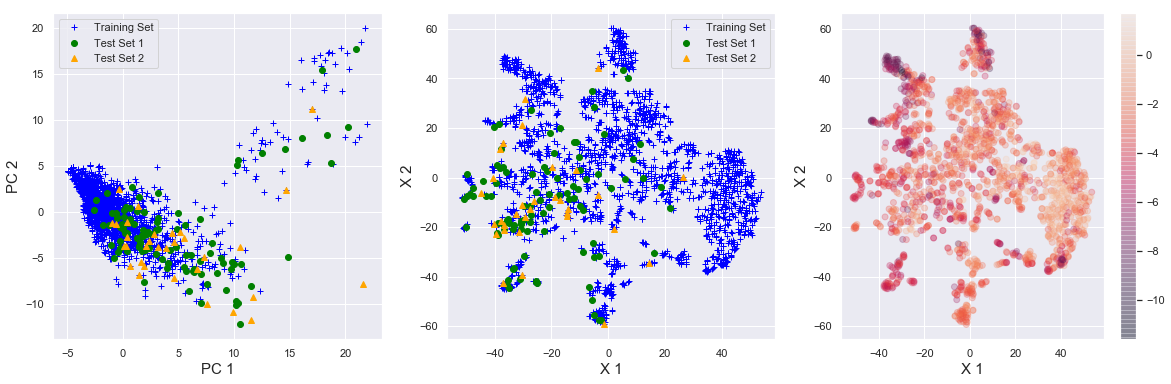

In [9]:
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]

y = np.cumsum(pca.explained_variance_ratio_)
x = [i+1 for i in range(len(y))]

# Each class correspond to the molecular target
color_map = {0:'blue', 1:'green', 2:'orange'}
marker_map = {0:'+', 1:'o', 2:'^'}
labels_map = {0:'Training Set', 1:'Test Set 1', 2:'Test Set 2'}

for label, color in color_map.items():
    x = [zscores_pca[i, 0] for i in range(len(labels)) if labels[i] == label]
    y = [zscores_pca[i, 1] for i in range(len(labels)) if labels[i] == label]
    ax1.plot(x, y, marker_map[label], c=color, label=labels_map[label])
ax1.legend()
ax1.set_xlabel("PC 1", fontsize=15)
ax1.set_ylabel("PC 2", fontsize=15)

# Embed first 50 PCs. 
X_embedded = TSNE(n_components=2).fit_transform(zscores_pca[:, 0:10])

for label, color in color_map.items():
    x = [X_embedded[i, 0] for i in range(len(labels)) if labels[i] == label]
    y = [X_embedded[i, 1] for i in range(len(labels)) if labels[i] == label]
    ax2.plot(x, y, marker_map[label], c=color, label=labels_map[label])
ax2.legend()
ax2.set_xlabel("X 1", fontsize=15)
ax2.set_ylabel("X 2", fontsize=15)

# Log_s0 in X1-X2 coordinate system
x = [X_embedded[i, 0] for i in range(len(labels)) if labels[i] == 0]
y = [X_embedded[i, 1] for i in range(len(labels)) if labels[i] == 0]

im = ax3.scatter(x, y, c=LOG_S0, alpha=0.25, label=labels_map[0])
ax3.set_xlabel("X 1", fontsize=15)
ax3.set_ylabel("X 2", fontsize=15)
fig.colorbar(im, ax=ax3)

**(A)** 2D projection in the Principal Components space. PCA was performed with all the data-points, _i.e._ training and two test sets. **(B)** 2D t-SNE embedding done with 10 most important PCs. **(C)** Same as (B) but only the training dataset is plotted and data-points are color coded according to their $\rm log S_0$ values.

### "Solubility cliffs"

Water solubility prediction is challenging; Not only is there a limited amount of data, it can also be problematic because the solubility is measured when the dissolved compound is in equilibrium with its own solid phase. For example, depending on the form of [Diflunisal](https://www.drugbank.ca/drugs/DB00861), four different solubilities were [measured](https://github.com/pgniewko/solubility/blob/master/papers/HEL.2009.JCIM.pdf), and these values can differ by 2 orders of magnitude (2 log units).

Another challenge may arise when two structurally similar compounds have significantly different solubility values, $\rm logS_0$. The paragraph below analyzes these cases, called here "solubility cliffs".

In [9]:
TRAINING_DATA = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)

smiles = []
logS = []

with open(TRAINING_DATA, 'r') as fin:
    for line in fin:
        pairs = line.rstrip().split(',')
        smiles.append(pairs[0])
        logS.append(float(pairs[1]))

In [10]:
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=1024) for x in smiles]

In [11]:
fps_sim = []
loS0_delta = []
compounds_1 = []
compounds_2 = []
index = 1
for i in range(len(fps)):
    for j in range(len(fps)):
        if j <= i:
            continue
        sim = sim_ij = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        fps_sim.append(sim)
        loS0_delta.append(abs(logS[i] - logS[j]))
        if sim > 0.7 and abs(logS[i] - logS[j]) > 2.0:
            compounds_1.append((smiles[i], logS[i], index, sim))
            compounds_2.append((smiles[j], logS[j], index))
            index += 1

#### Distribution of the compounds similaritues and differences in the training dataset.

Text(0, 0.5, '$logS_0$ differene')

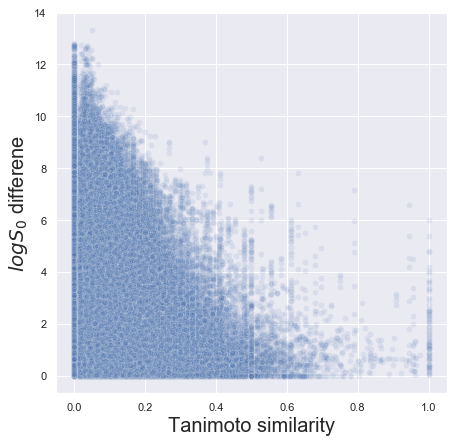

In [12]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(fps_sim, loS0_delta, markers='.', alpha=0.1)
plt.xlabel('Tanimoto similarity', fontsize=20)
plt.ylabel('$logS_0$ differene', fontsize=20)

As we can see, there is some number of compounds that are very similar to each other (similarity > 0.7), and having $\Delta(log S_0) > 2$. Let's see how they look like!

,Mol-1,Mol-2,Tanimoto,logS0-1,logS0-2,Delta
0,,,1.000000,-3.6300,-7.2080,3.5780
1,,,0.789474,-3.6300,-1.2400,2.3900
2,,,1.000000,-3.6300,-8.4000,4.7700
3,,,1.000000,-3.6300,-6.3500,2.7200
4,,,1.000000,-3.6300,-6.0080,2.3780
5,,,0.944444,-4.7025,-1.8100,2.8925
6,,,1.000000,-4.7025,-7.2080,2.5055
7,,,0.789474,-4.7025,-1.2400,3.4625
8,,,1.000000,-4.7025,-8.4000,3.6975
9,,,1.000000,-4.7025,-2.3900,2.3125

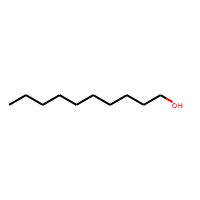
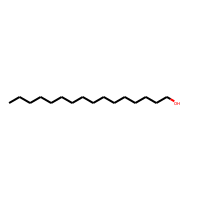
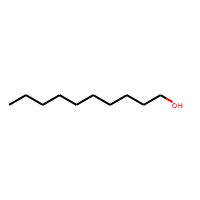
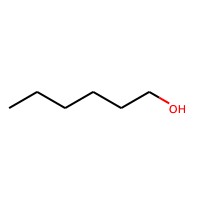
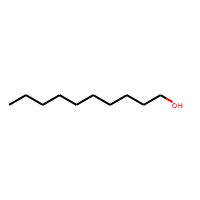
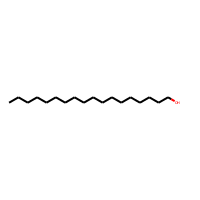
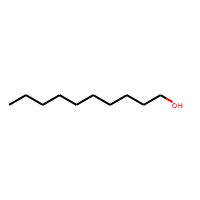
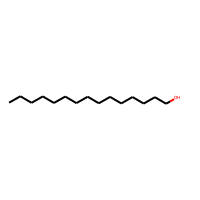
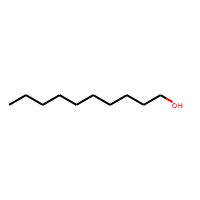
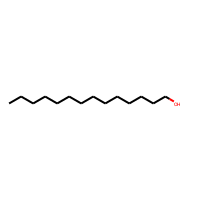
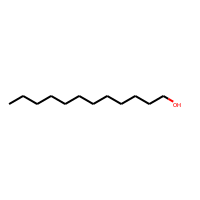
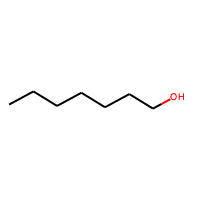
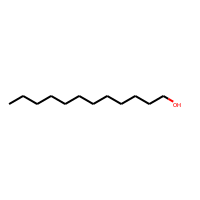
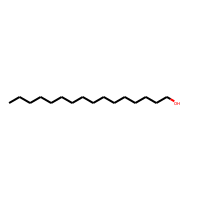
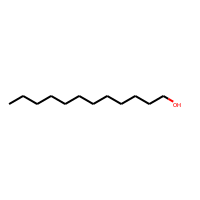
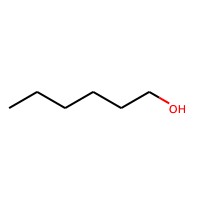
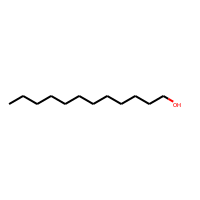
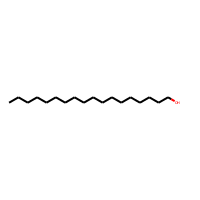
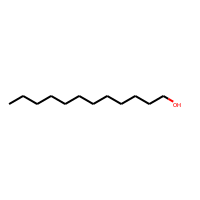
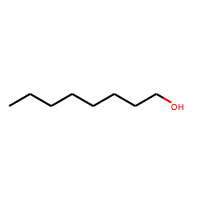
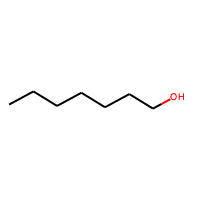
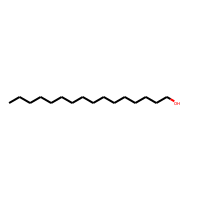
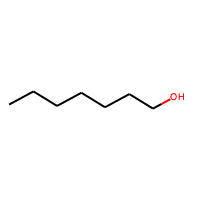
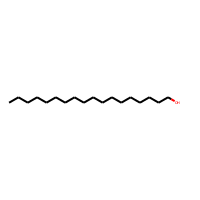
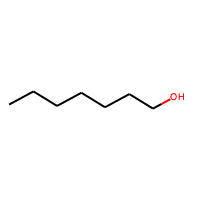
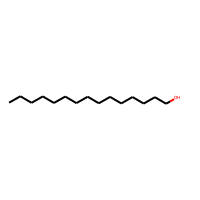
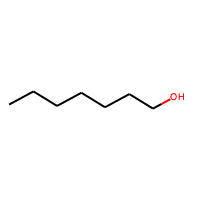
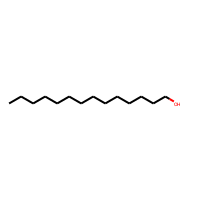
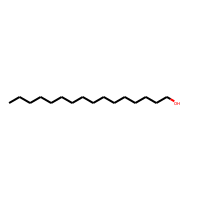
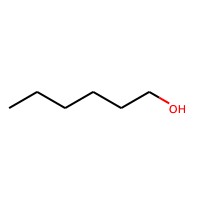
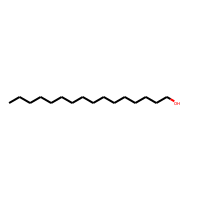
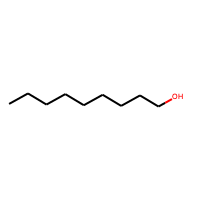
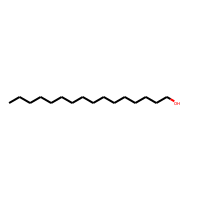
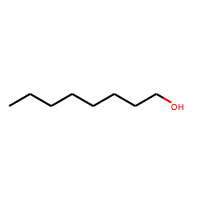
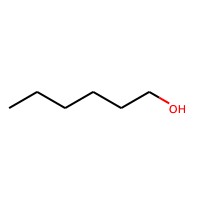
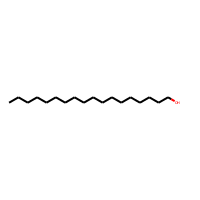
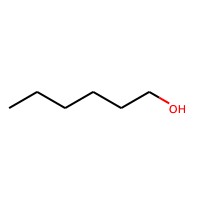
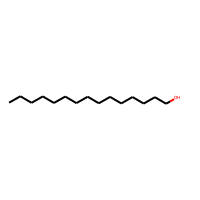
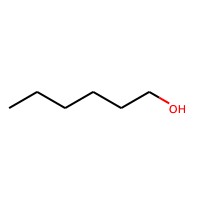
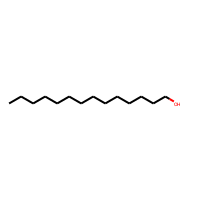
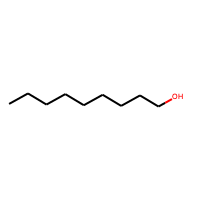
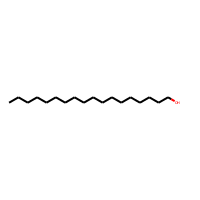
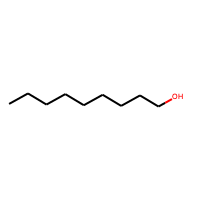
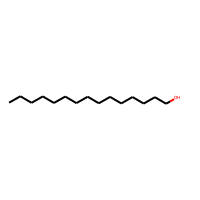
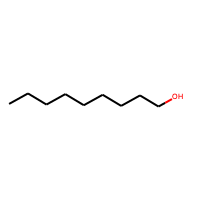
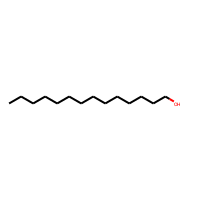
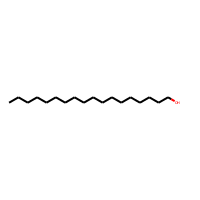
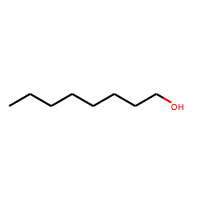
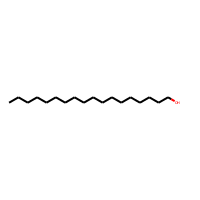
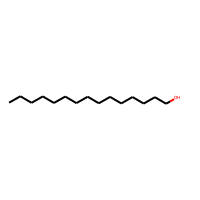
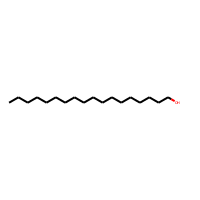
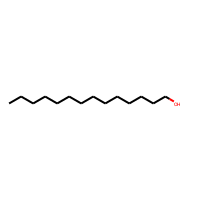
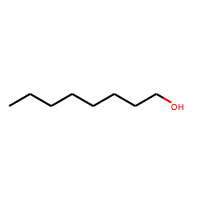
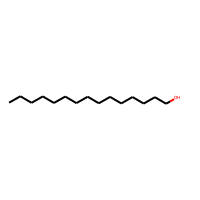
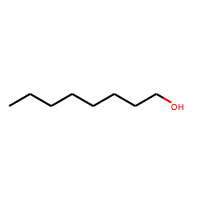
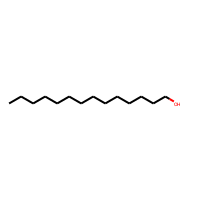
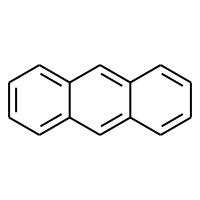
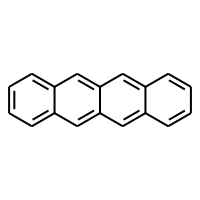
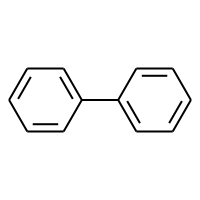
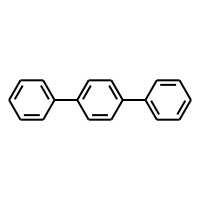
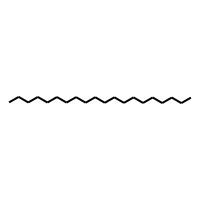
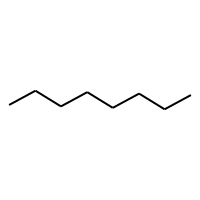
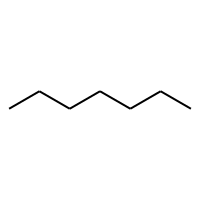
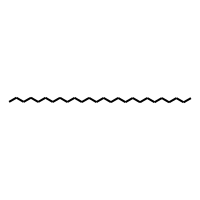
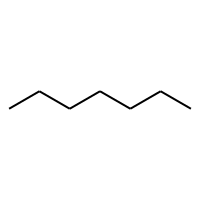
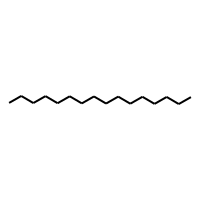
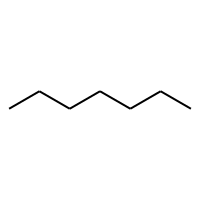
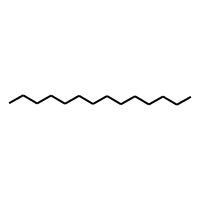
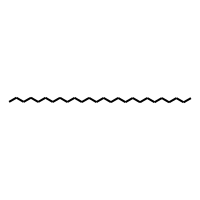
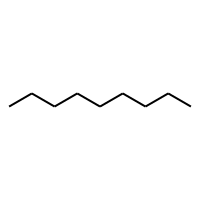
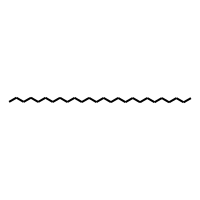
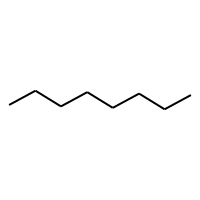
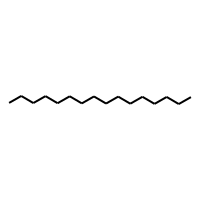
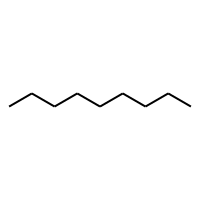
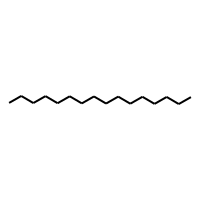
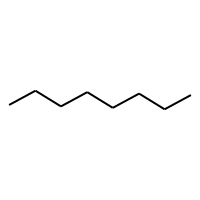
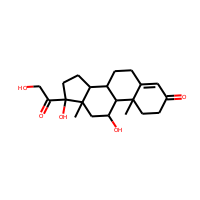
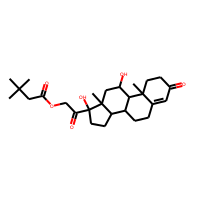
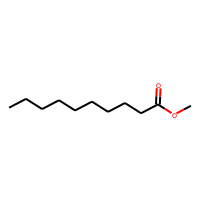
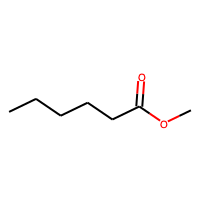
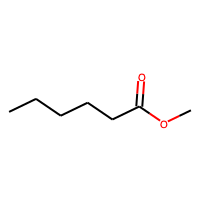
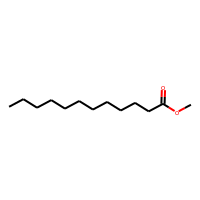
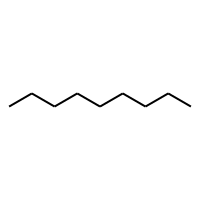
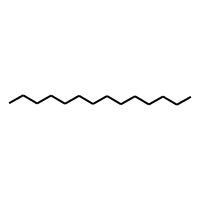
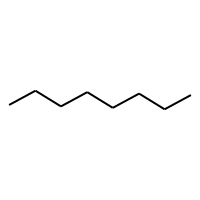
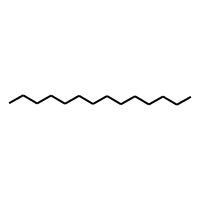
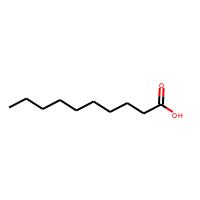
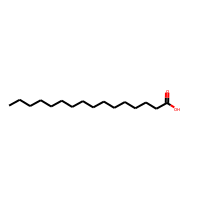
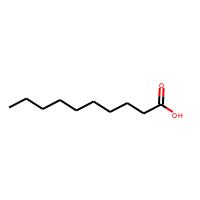
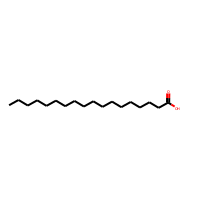
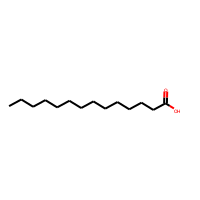
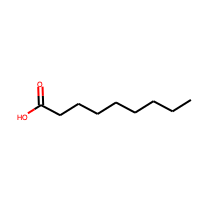
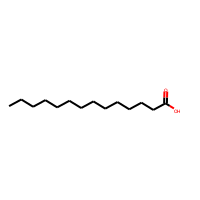
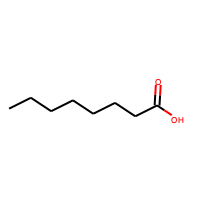
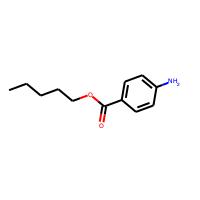
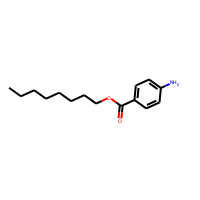
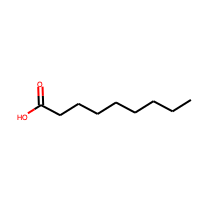
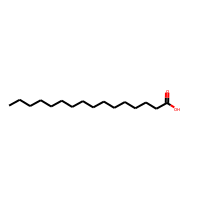
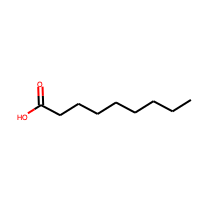
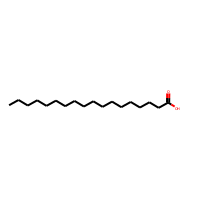
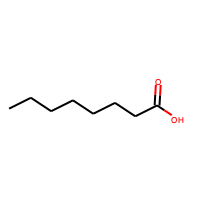
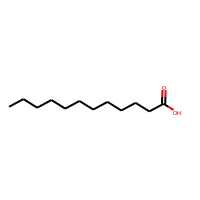
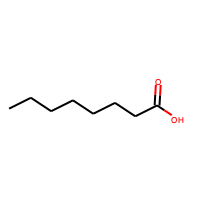
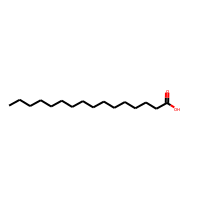
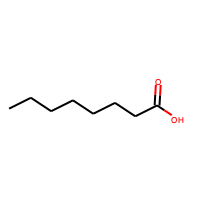
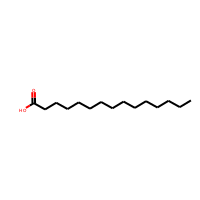
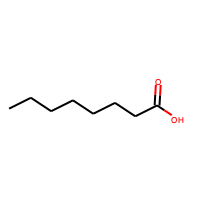
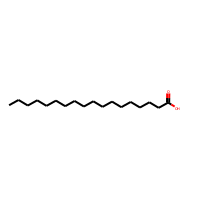
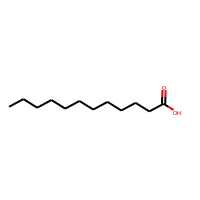
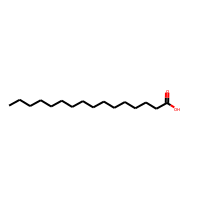
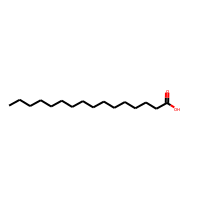
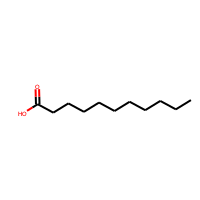
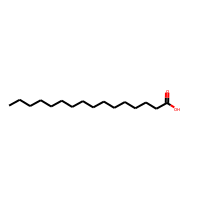
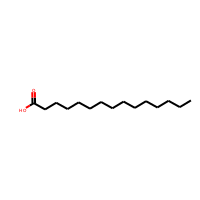
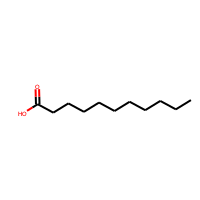
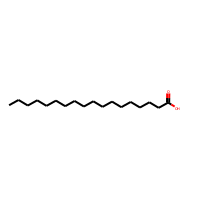
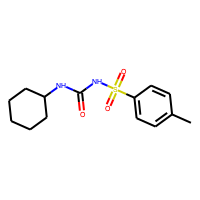
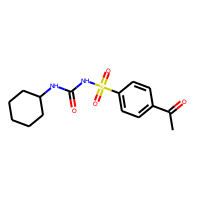
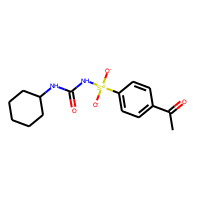
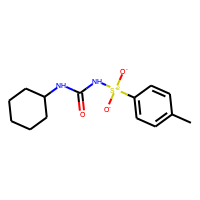

In [13]:
df_1 = pd.DataFrame(compounds_1, columns=['Smiles', 'logS0', 'index', 'sim'])
df_2 = pd.DataFrame(compounds_2, columns=['Smiles', 'logS0', 'index'])
PandasTools.AddMoleculeColumnToFrame(df_1)
PandasTools.AddMoleculeColumnToFrame(df_2)

df= df_1.merge(df_2, left_on='index', right_on='index')
df.columns = ['Smiles-1', 'logS0-1', 'index', 'Tanimoto', 'Mol-1', 'Smiles-2', 'logS0-2', 'Mol-2']
df = df.drop(['Smiles-1', 'Smiles-2','index'],axis=1)
df = df[['Mol-1', 'Mol-2', 'Tanimoto', 'logS0-1','logS0-2']]
df['Delta'] = abs(df['logS0-1'] - df['logS0-2'])
df

The number of pairs with very similar structure and yet different solubility is 63. These pairs are mostly for symmetric and aromotic compounds or aliphatic acids and alcohols. In these cases we can see that a substitution of an additional $-CH_3$ group may lead to a significant change of the compound solubilty.